# CS289A Project F : Learning HW Acceleration Performance
## Final results, excpet for NN

In [1]:
from collections import Counter
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
import pandas as pd
import random

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import warnings
warnings.filterwarnings('ignore')

random.seed(246810)
np.random.seed(246810)

In [2]:
eps = 1e-5  # a small number
# Vectorized function for hashing for np efficiency
def w(x):
    return np.int(hash(x)) % 1000

h = np.vectorize(w)


## 1. Set up dataset

In [3]:
# some scripts to merge the SW time and HW time + features CSV files
# no need to run again !!

# path_chstone= '../data/baseline_chstone.csv'
# chstone = pd.read_csv(path_chstone, delimiter=',')

# path_random = '../data/baseline_random.csv'
# random = pd.read_csv(path_random, delimiter=',')
# random.sort_values(by = ['program'])

# random_sw=pd.read_csv('../data/sw_perf_random.csv', delimiter=',')
# chstone_sw=pd.read_csv('../data/sw_perf_chstone.csv', delimiter=',')

# merged_random = random.merge(random_sw, left_on='program', right_on='program')
# merged_chstone = chstone.merge(chstone_sw, left_on='program', right_on='program')

# merged_random.to_csv('../data/final_random.csv', index=False)
# merged_chstone.to_csv('../data/final_chstone.csv',index=False)


In [4]:
dataset = "csmith_random_programs"
data = pd.read_csv('../data/final_random.csv', delimiter=',')

### Part (a). Pre-process the data


In [5]:
# Parition Dataset-> Train : Test = 85 : 15 (for non-NN), Train : Val : Test = 70:15:15 for NN
# for non-NN, we use 3-fold cross validation (using sklearn crossvalscore)

num_train = round(np.shape(data)[0]*0.7)
train_data = data.values[0:num_train,:]
test_data =  data.values[num_train:, :]
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state = 0, shuffle=False)
train_data = np.concatenate((train_data, val_data), axis=0)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(data))

train_speedup = (train_data[:, -1] / train_data[:, 2]) # 
test_speedup = (test_data[:, -1] / test_data[:, 2]) # -O3

# Get binary speedup prediction output: Is speedup from HW acceleration > 2800x ?
y = (train_speedup > 2800).astype(int)
X = train_data[:,-57:-1] # -O3 features
y_test = (test_speedup > 2800).astype(int)
X_test = test_data[:,-57:-1] # -O3 features
print(np.count_nonzero(y) / len(y))
print(np.count_nonzero(y_test) / len(y_test))
assert(len(y) == np.shape(train_data)[0])
assert(len(y_test) == np.shape(test_data)[0] )

features = data.columns.values[-57:-1]
assert len(features) == 56
class_names = ["On-Chip", "Not On-Chip"]

(10942, 116)
(1931, 116)
(12873, 116)
0.5449643575214769
0.541170378042465


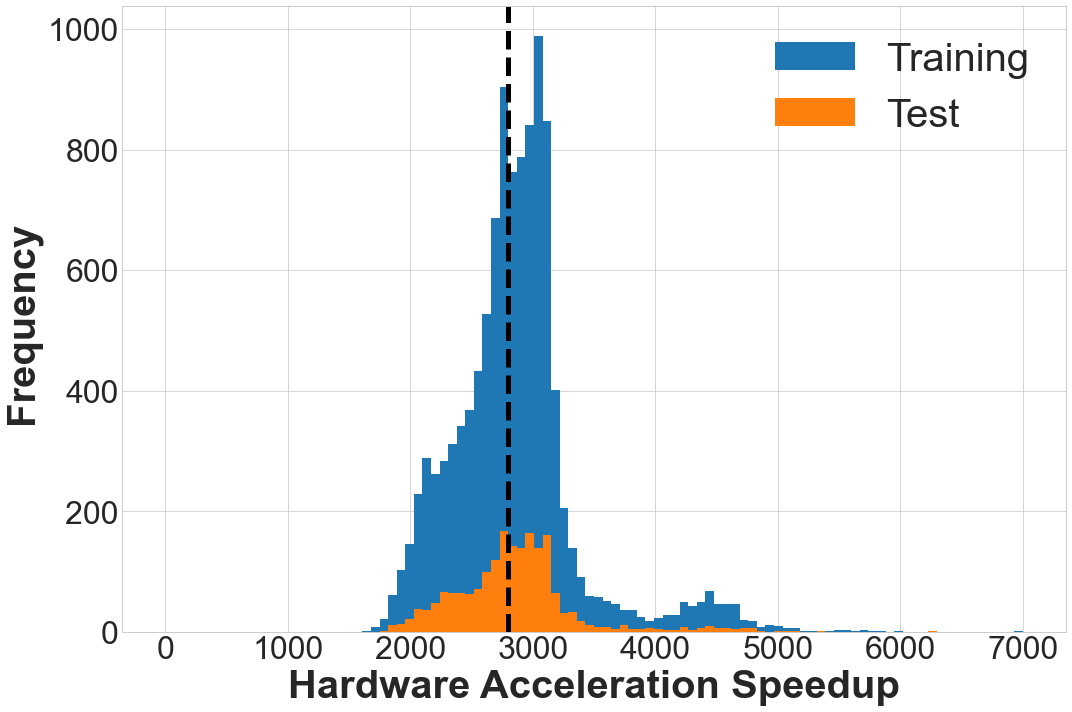

In [6]:
# Print speedup distribution
fontsize=40
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(15,10),nrows=1, ncols=1, constrained_layout=False)

ax.set_ylabel("Frequency ", fontsize=fontsize, weight='bold' )
ax.set_xlabel("Hardware Acceleration Speedup", fontsize=fontsize,weight='bold' )
ax.tick_params(axis='x', labelsize=fontsize*0.8) # change the fontsize for xticks label (for all layers)
ax.tick_params(axis='y', labelsize=fontsize*0.8) # change the fontsize for xticks label (for all layers)


ax.yaxis.grid()
ax.xaxis.grid()


plt.hist(train_speedup, bins=100, range =(0, 7000))
plt.hist(test_speedup, bins=100, range =(0, 7000))
ax.legend(['Training', 'Test'], fontsize=fontsize, fancybox=True, framealpha=1.0)
plt.axvline(2800, lw=5, ls='--', color='black') 

ax.grid()
plt.tight_layout()
plt.savefig('random_speedup_dist.pdf')
plt.show()

## Log Reg ##

In [7]:
# Scale data
clf = make_pipeline(StandardScaler(), LogisticRegression())
clf.get_params()
#Do grid search to optimize hyperparameters
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1], 'logisticregression__penalty': ['l1','l2', 'elasticnet']}

# Use default 3-fold CV
grid = GridSearchCV(clf,param_grid,refit=True,verbose=2, n_jobs = -1)
grid.fit(X,y)
print("Best params:")
print(grid.best_estimator_.get_params())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s


Best params:
{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression(C=0.01))], 'verbose': False, 'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(C=0.01), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'logisticregression__C': 0.01, 'logisticregression__class_weight': None, 'logisticregression__dual': False, 'logisticregression__fit_intercept': True, 'logisticregression__intercept_scaling': 1, 'logisticregression__l1_ratio': None, 'logisticregression__max_iter': 100, 'logisticregression__multi_class': 'auto', 'logisticregression__n_jobs': None, 'logisticregression__penalty': 'l2', 'logisticregression__random_state': None, 'logisticregression__solver': 'lbfgs', 'logisticregression__tol': 0.0001, 'logisticregression__verbose': 0, 'logisticregression__warm_start': False}


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished


In [10]:
print("Best Estimator: Test Accuracy")
print(grid.score(X_test, y_test))
print("Best Estimator: Avg Cross-Validataion Accuracy")
print(grid.best_score_)

Best Estimator: Test Accuracy
0.7628171931641636
Best Estimator: Avg Cross-Validataion Accuracy
0.769969216198994


In [11]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions, digits=3))#Output

[[561 325]
 [133 912]]
              precision    recall  f1-score   support

           0      0.808     0.633     0.710       886
           1      0.737     0.873     0.799      1045

    accuracy                          0.763      1931
   macro avg      0.773     0.753     0.755      1931
weighted avg      0.770     0.763     0.758      1931



## SVM ##

In [ ]:
svm = make_pipeline(StandardScaler(), SVC())
param_grid = {'svc__C': [0.01, 0.1, 1, 10], 'svc__gamma': [0.001, 0.1, 1], 'svc__kernel': ['rbf', 'poly']}
grid_svm = GridSearchCV(svm,param_grid,refit=True,verbose = 1, n_jobs = -1, cv=3)
grid_svm.fit(X,y)
print("Best params:")
print(grid_svm.best_estimator_.get_params())

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min


In [ ]:
print("Best Estimator: Test Accuracy")
print(grid_svm.score(X_test, y_test))
print("Best Estimator: Avg Cross-Validataion Accuracy")
print(grid_svm.best_score_)

In [ ]:
grid_svm_predictions = grid_svm.predict(X_test)
print(confusion_matrix(y_test,grid_svm_predictions))
print(classification_report(y_test,grid_svm_predictions, digits=3))#Output

## Random Forest ##

In [13]:
# Scale data
rf = RandomForestClassifier()
#Do grid search to optimize hyperparameters
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10],
    'min_samples_leaf': [15, 20, 25, 30],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [300, 350, 400, 450,500],
    'max_features':['sqrt']
}
# Use default 5-fold CV
grid_rf = GridSearchCV(rf,param_grid,refit=True,verbose = 1, n_jobs=-1)
grid_rf.fit(X,y)
print("Best params:")
print(grid_rf.best_estimator_.get_params())

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.8min finished


Best params:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 25, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 450, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [14]:
print("Best Estimator: Test Accuracy")
print(grid_rf.score(X_test, y_test))
print("Best Estimator: Avg Cross-Validataion Accuracy")
print(grid_rf.best_score_)

Best Estimator: Test Accuracy
0.7674779906784049
Best Estimator: Avg Cross-Validataion Accuracy
0.7734420816063031


In [15]:
grid_rf_predictions = grid_rf.predict(X_test)
print(confusion_matrix(y_test,grid_rf_predictions))
print(classification_report(y_test,grid_rf_predictions, digits=3))#Output

[[562 324]
 [125 920]]
              precision    recall  f1-score   support

           0      0.818     0.634     0.715       886
           1      0.740     0.880     0.804      1045

    accuracy                          0.767      1931
   macro avg      0.779     0.757     0.759      1931
weighted avg      0.776     0.767     0.763      1931



## AdaBoost ##

In [21]:
# Scale data
ada = AdaBoostClassifier()
#Do grid search to optimize hyperparameters
param_grid = {
    'learning_rate' : [0.001, 0.01, 0.1],
    'n_estimators': [400, 500, 600]}
# Use default 3-fold CV
grid_ada = GridSearchCV(ada,param_grid,refit=True, verbose = 1, n_jobs=-1)
grid_ada.fit(X,y)
print("Best params:")
print(grid_ada.best_estimator_.get_params())

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.8min finished


Best params:
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.1, 'n_estimators': 600, 'random_state': None}


In [22]:
print("Best Estimator: Test Accuracy")
print(grid_ada.score(X_test, y_test))
print("Best Estimator: Avg Cross-Validataion Accuracy")
print(grid_ada.best_score_)
grid_ada_predictions = grid_ada.predict(X_test)
print(confusion_matrix(y_test,grid_ada_predictions))
print(classification_report(y_test,grid_ada_predictions, digits=3))#Output

Best Estimator: Test Accuracy
0.7633350595546349
Best Estimator: Avg Cross-Validataion Accuracy
0.7685063085577025
[[569 317]
 [140 905]]
              precision    recall  f1-score   support

           0      0.803     0.642     0.713       886
           1      0.741     0.866     0.798      1045

    accuracy                          0.763      1931
   macro avg      0.772     0.754     0.756      1931
weighted avg      0.769     0.763     0.759      1931



## Gradient Boosting Classifier ##

In [26]:
gb = GradientBoostingClassifier()
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.001, 0.01],
    "min_samples_split": [2],
    "min_samples_leaf": [5],
    "max_depth":[5,10],
    "max_features":["sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 1.0],
    "n_estimators":[200,300]
    }

grid_gb = GridSearchCV(gb,param_grid,refit=True, verbose = 1, n_jobs=-1, cv = 3)
grid_gb.fit(X, y)
print(grid_gb.best_estimator_.get_params())

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 0.5, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [27]:
print("Best Estimator: Test Accuracy")
print(grid_gb.score(X_test, y_test))
print("Best Estimator: Avg Cross-Validataion Accuracy")
print(grid_gb.best_score_)
grid_gb_predictions = grid_gb.predict(X_test)
print(confusion_matrix(y_test,grid_gb_predictions))
print(classification_report(y_test,grid_gb_predictions, digits=3))#Output

Best Estimator: Test Accuracy
0.7669601242879337
Best Estimator: Avg Cross-Validataion Accuracy
0.7741727158587447
[[556 330]
 [120 925]]
              precision    recall  f1-score   support

           0      0.822     0.628     0.712       886
           1      0.737     0.885     0.804      1045

    accuracy                          0.767      1931
   macro avg      0.780     0.756     0.758      1931
weighted avg      0.776     0.767     0.762      1931

